In [7]:
# @title Imports
import math, array, gc, gzip, os, struct, urllib.request, time
from os import path
import pickle
from tqdm.notebook import tqdm

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from scipy.linalg import svd
import scipy.sparse as sp

from mds import *

import matplotlib.pyplot as plt
import scprep
import m_phate
import m_phate.train
import m_phate.data

import numpy as np

In [1071]:
!ls data

decoder_trace_0.npy	     embedding_1234_lr.npy	x_trace.npy
decoder_trace_0_smalllr.npy  embedding_12_lr.npy	y_trace.npy
decoder_trace_1.npy	     embedding_12.npy
decoder_trace_1_smalllr.npy  embedding_256_lrsched.npy


In [293]:
trace_data1 = np.load('./data/decoder_trace_0.npy')
trace_data2 = np.load('./data/decoder_trace_1.npy')
x_trace = np.load('./data/x_trace.npy')
y_trace = np.load('./data/y_trace.npy')
embedding_12 = np.load('./data/embedding_12.npy')
embedding_12_lr = np.load('./data/embedding_12_lr.npy') 
embedding_1234_lr = np.load('./data/embedding_256_lrsched.npy') 
embedding_1234_lr = np.load('./data/embedding_1234_lr.npy') 

trace_data1.shape, trace_data2.shape

((101, 100, 512), (101, 100, 512))

In [294]:
embedding_12 = embedding_1234_lr

In [298]:
# for plots of hidden units in time
n_epochs = trace_data1.shape[0]
n_neurons = trace_data1.shape[-1]
n_samples = trace_data1.shape[1]

# the unique neuron id for each element of the flattened trace
neuron_ids = np.tile(np.arange(n_neurons), n_epochs)

# the current epoch for each element of the flattened trace
epoch = np.repeat(np.arange(n_epochs), n_neurons)

# the label of each digit we selected: this should be the same as `np.repeat(np.arange(10), 10)`
digit_ids = y_trace
#digit_ids = list(np.tile(y_trace, 51)) + list(np.tile(y_trace, 51))
n_networks = 4
target_density = 1/n_networks
y_network = np.array([0]*100+[1]*100+[2]*100+[3]*100)
y_network = np.array([0]*100+[1]*100+[2]*100)
y_network = np.array([0]*100+[1]*100)


In [308]:
idx = list(np.repeat(np.arange(51), 100)>5)*4
X = embedding_12[idx].reshape(100*n_networks,-1)
n_clust = 50
kmeans = KMeans(n_clusters=n_clust, random_state=0).fit(X)
avg_clust_size = np.mean([(kmeans.labels_==clusterid).sum() for clusterid in range(n_clust)])
std_clust_size = np.std([(kmeans.labels_==clusterid).sum() for clusterid in range(n_clust)])
avg_clust_size, std_clust_size

(8.0, 4.233202097703345)

In [309]:
densities = []
for clusterid in range(n_clust):
    """for each cluster, how many network labels match?"""
    pos_samples = (kmeans.labels_==clusterid)
    density = (y_network[pos_samples]==0).sum()/pos_samples.sum()
    densities.append(density)
    
np.set_printoptions(precision=1, linewidth=np.inf)
print(np.array(densities))
print(np.square(np.array(densities) - target_density))
print(np.linalg.norm(np.array(densities) - target_density)**2)
deviations = np.linalg.norm(np.array(densities) - target_density)**2

[0.1 0.2 0.3 0.  0.2 0.  0.4 0.2 0.  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.  0.3 0.2 0.  0.  0.2 0.4 0.2 0.4 0.  0.2 0.  0.  0.2 0.4 0.  0.  0.2 0.  0.4 0.3 0.3 0.  0.4 0.4 0.3 0.  0.3 0.5 0.3 0.3 0.3 0.3 0.4]
[0.  0.  0.  0.1 0.  0.1 0.  0.  0.1 0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.1 0.1 0.  0.  0.  0.  0.1 0.  0.1 0.1 0.  0.  0.1 0.1 0.  0.1 0.  0.  0.  0.1 0.  0.  0.  0.1 0.  0.1 0.  0.  0.  0.  0. ]
1.1796701388888888


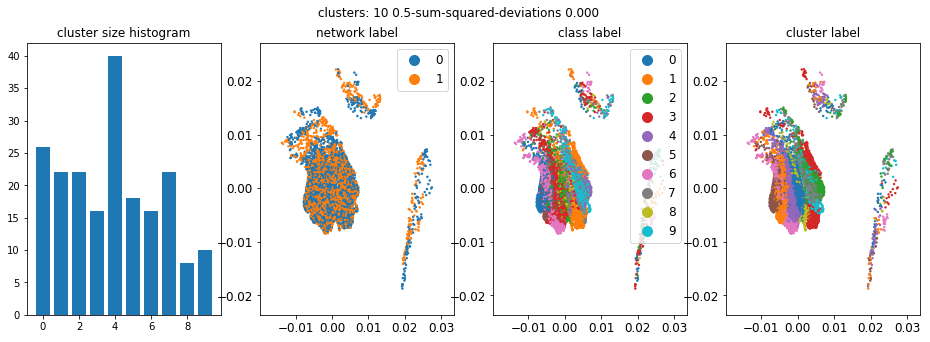

In [1070]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(16,5))
fig.suptitle('clusters: {} 0.5-sum-squared-deviations {:.3f}'.format(
        n_clust, 
        deviations))
ax1.set_title('cluster size histogram')
ax1.bar(list(range(n_clust)),np.array([(kmeans.labels_==clusterid).sum() for clusterid in range(n_clust)]))
ax2.set_title('network label')
scprep.plot.scatter2d(embedding_12, c=list(np.tile(y_network, 51)), ax=ax2)
ax3.set_title('class label')
scprep.plot.scatter2d(embedding_12, c=list(np.tile(y_trace, 51)) + list(np.tile(y_trace, 51)), ax=ax3)
ax4.set_title('cluster label')
scprep.plot.scatter2d(embedding_12, c=np.tile(kmeans.labels_, 51),ax=ax4,legend=False)